# Data Exploration

---

**Author:** Diego Antonio García Padilla

**Date:** Oct 29, 2025

## Enviroment setup

In [1]:
#@title Setup & Environment Verification

import warnings
warnings.filterwarnings('ignore')

import os
import sys

print("=== ENVIRONMENT CHECK ===")
print(f"Python: {sys.version.split()[0]}")
print(f"JAVA_HOME: {os.environ.get('JAVA_HOME')}")
print(f"SPARK_HOME: {os.environ.get('SPARK_HOME')}")
print(f"Driver Memory: {os.environ.get('SPARK_DRIVER_MEMORY')}")
print(f"Executor Memory: {os.environ.get('SPARK_EXECUTOR_MEMORY')}")
print("=" * 50)

=== ENVIRONMENT CHECK ===
Python: 3.10.12
JAVA_HOME: /usr/lib/jvm/java-8-openjdk-arm64/jre
SPARK_HOME: /opt/spark
Driver Memory: 6g
Executor Memory: 3g


In [2]:
#@title Import Libraries

# PySpark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.window import Window

# Data manipulation
import pandas as pd
import numpy as np

# Financial data
import yfinance as yf

# Hugging Face
from huggingface_hub import hf_hub_download

# Utilities
from datetime import datetime, timedelta
import json
import requests
import logging
from tqdm import tqdm
import time

In [3]:
#@title Start Spark session

print("=== PRE-FLIGHT CHECK ===")

# Auto-detect JAVA_HOME if not set properly
def find_java_home():
    try:
        # Method 1: Use 'which java' and follow symlinks
        java_path = subprocess.check_output(['which', 'java'], text=True).strip()
        java_home = os.path.dirname(os.path.dirname(os.path.realpath(java_path)))
        return java_home
    except:
        # Method 2: Common locations
        common_paths = [
            '/usr/lib/jvm/java-8-openjdk-amd64',
            '/usr/lib/jvm/java-8-openjdk-arm64',
            '/usr/lib/jvm/default-java',
            '/usr/lib/jvm/java-8-openjdk',
        ]
        for path in common_paths:
            if os.path.exists(os.path.join(path, 'bin', 'java')):
                return path
        return None

# Check current JAVA_HOME
current_java_home = os.environ.get('JAVA_HOME')
print(f"Current JAVA_HOME: {current_java_home}")

# Verify Java executable exists
if current_java_home:
    java_bin = os.path.join(current_java_home, 'bin', 'java')
    if not os.path.exists(java_bin):
        print(f"⚠️  Java not found at {java_bin}")
        detected_java_home = find_java_home()
        if detected_java_home:
            os.environ['JAVA_HOME'] = detected_java_home
            print(f"✅ Auto-detected JAVA_HOME: {detected_java_home}")
        else:
            print("❌ Could not find Java installation")
    else:
        print(f"✅ Java found at {java_bin}")
else:
    detected_java_home = find_java_home()
    if detected_java_home:
        os.environ['JAVA_HOME'] = detected_java_home
        print(f"✅ Auto-detected JAVA_HOME: {detected_java_home}")

print(f"SPARK_HOME: {os.environ.get('SPARK_HOME', 'NOT SET')}")

# Verify Java is accessible
try:
    java_version = subprocess.check_output(['java', '-version'], stderr=subprocess.STDOUT)
    print(f"Java: ✅ Available")
except Exception as e:
    print(f"Java: ❌ Not available - {e}")

print("=" * 50)

from pyspark.sql import SparkSession

try:
    # Stop any existing Spark sessions
    SparkSession.builder.getOrCreate().stop()
except:
    pass

# Create new session
spark = SparkSession.builder \
    .appName("SAPS_Portfolio_Optimizer") \
    .master("local[*]") \
    .config("spark.driver.host", "127.0.0.1") \
    .config("spark.driver.bindAddress", "127.0.0.1") \
    .config("spark.ui.port", "4040") \
    .config("spark.driver.memory", "6g") \
    .config("spark.executor.memory", "3g") \
    .config("spark.driver.maxResultSize", "3g") \
    .config("spark.sql.shuffle.partitions", "60") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.memory.fraction", "0.8") \
    .config("spark.memory.storageFraction", "0.3") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.kryoserializer.buffer.max", "512m") \
    .config("spark.sql.files.maxPartitionBytes", "128MB") \
    .config("spark.sql.autoBroadcastJoinThreshold", "50MB") \
    .config("spark.local.dir", "/tmp/spark") \
    .config("spark.eventLog.enabled", "false") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")

print(f"\n✅ Spark {spark.version} initialized successfully")
print(f"   Master: {spark.sparkContext.master}")
print(f"   App Name: {spark.sparkContext.appName}")
print(f"   Available cores: {spark.sparkContext.defaultParallelism}")
print(f"   Spark UI: http://localhost:4040")

=== PRE-FLIGHT CHECK ===
Current JAVA_HOME: /usr/lib/jvm/java-8-openjdk-arm64/jre
✅ Java found at /usr/lib/jvm/java-8-openjdk-arm64/jre/bin/java
SPARK_HOME: /opt/spark
Java: ❌ Not available - name 'subprocess' is not defined


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/04 00:37:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable



✅ Spark 3.5.6 initialized successfully
   Master: local[*]
   App Name: SAPS_Portfolio_Optimizer
   Available cores: 6
   Spark UI: http://localhost:4040


25/11/04 00:37:14 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


## Download data

### Stock Prices from `yfinance`

In [4]:
#@title Get S&P 500 companies and select diversified portfolio

TICKERS_NUMBER = 100
tickers_file = '../data/selected_tickers.txt'

# Check if tickers file already exists
if os.path.exists(tickers_file):
    print(f"✅ File '{tickers_file}' already exists. Loading tickers...")
    with open(tickers_file, 'r') as f:
        selected_tickers = [line.strip() for line in f.readlines()]
    print(f"Loaded {len(selected_tickers)} tickers from file")
else:
    print("Fetching S&P 500 companies from Wikipedia...")
    
    # URL of the Wikipedia page listing S&P 500 companies
    url = "https://en.wikipedia.org/wiki/List_of_S&P_500_companies"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36"
    }
    
    # Fetch the HTML content
    response = requests.get(url, headers=headers)
    
    # Read the S&P 500 table
    sp500_data = pd.read_html(response.text)[0]
    print(f"Successfully retrieved {len(sp500_data)} S&P 500 companies")
    
    # Define sector allocation (100 stocks total)
    sector_allocation = {
        'Information Technology': 20,
        'Financials': 15,
        'Health Care': 15,
        'Consumer Discretionary': 15,
        'Energy': 10,
        'Industrials': 10,
        'Consumer Staples': 5,
        'Real Estate': 5,
        'Utilities': 5
    }
    
    # Tickers to exclude
    excluded_tickers = ['BRK.B', 'BF.B', 'ABNB', 'ABT', 'AEP', 'APA', 'APTV', 'AXON', 'BKNG', 'BKR', 'CAH', 'CRWD', 'CTRA', 'CVX', 'DASH', 'DDOG', 'DELL', 'GLW', 'XYZ', 'ATO', 'CARR', 'FFIV']
    
    # Select diversified stocks by sector
    selected_tickers = []
    for sector, count in sector_allocation.items():
        sector_stocks = sp500_data[sp500_data['GICS Sector'] == sector]['Symbol'].tolist()
        # Filter out excluded tickers
        sector_stocks = [ticker for ticker in sector_stocks if ticker not in excluded_tickers]
        selected_tickers.extend(sector_stocks[:count])
    
    print(f"\nTotal tickers selected: {len(selected_tickers)}")
    
    # Save for later use
    with open(tickers_file, 'w') as f:
        f.write('\n'.join(selected_tickers))
    print(f"✅ Tickers saved to '{tickers_file}'")
    print(f"Tickers: ", len(selected_tickers))

✅ File '../data/selected_tickers.txt' already exists. Loading tickers...
Loaded 100 tickers from file


In [5]:
#@title Get stock prices from yfinance

# Download price data for selected tickers
start_date = '2015-01-01'
end_date = '2025-01-01'

# Check if file already exists
csv_file = '../data/raw/sp500_prices_raw.csv'

if os.path.exists(csv_file):
    print(f"✅ File '{csv_file}' already exists. Skipping download.")
else:
    print(f"Downloading data for {len(selected_tickers)} tickers...")

    # Get selected tickers
    selected_tickers = pd.read_csv('../data/selected_tickers.txt', header=None)[0].tolist()

    # Download all data at once
    all_data = yf.download(
        selected_tickers,
        start=start_date,
        end=end_date,
        group_by='ticker',
        threads=True,
        progress=True
    )

    print(f"Downloaded data for {len(selected_tickers)} tickers")

    # Save to CSV for PySpark processing
    all_data.to_csv(csv_file, index=False)

✅ File '../data/raw/sp500_prices_raw.csv' already exists. Skipping download.


In [6]:
#@title Convert into PySpark dataframe (Part 1)

# File
sp500_file = '../data/raw/sp500_prices_raw.csv'
parquet_file = '../data/raw/sp500_prices_parquet.parquet'

# Read the multi-index CSV from yfinance
price_df_pandas = pd.read_csv(sp500_file, header=[0,1], index_col=0, parse_dates=True)

# Flatten the multi-index structure to long format
price_data_list = []

for ticker in price_df_pandas.columns.get_level_values(0).unique():
    try:
        # Extract data for this ticker
        ticker_df = price_df_pandas[ticker].copy()
        ticker_df['ticker'] = ticker
        ticker_df['date'] = ticker_df.index

        # Rename columns to lowercase
        ticker_df = ticker_df.rename(columns={
            'Open': 'open',
            'High': 'high',
            'Low': 'low',
            'Close': 'close',
            'Volume': 'volume'
        })

        # Select only required columns
        ticker_df = ticker_df[['date', 'ticker', 'open', 'high', 'low', 'close', 'volume']]

        price_data_list.append(ticker_df)

    except Exception as e:
        print(f"Error processing {ticker}: {e}")

# Concatenate all ticker dataframes
price_df_long = pd.concat(price_data_list, ignore_index=True)

# Add adj_close as close for now
price_df_long['adj_close'] = price_df_long['close']

# FIX: Convert date to string to avoid timestamp precision issues
price_df_long['date'] = price_df_long['date'].dt.strftime('%Y-%m-%d')

print(f"Long format created: {len(price_df_long)} rows")
print(f"Unique tickers: {price_df_long['ticker'].nunique()}")

# Save as parquet (now with date as string)
price_df_long.to_parquet(parquet_file, index=False, engine='pyarrow')
print(f"Saved to {parquet_file}")

Long format created: 251600 rows
Unique tickers: 100
Saved to ../data/raw/sp500_prices_parquet.parquet


In [7]:
#@title Convert into PySpark dataframe (Part 2)

from pyspark.sql.types import StructType, StructField, DateType, StringType, DoubleType, LongType

# Load parquet with date as string
price_spark_df = spark.read.parquet('../data/raw/sp500_prices_parquet.parquet')

# Convert string date to proper DateType
price_spark_df = price_spark_df \
    .withColumn("date", F.to_date(F.col("date"), "yyyy-MM-dd")) \
    .withColumn("open", F.col("open").cast("double")) \
    .withColumn("high", F.col("high").cast("double")) \
    .withColumn("low", F.col("low").cast("double")) \
    .withColumn("close", F.col("close").cast("double")) \
    .withColumn("adj_close", F.col("adj_close").cast("double")) \
    .withColumn("volume", F.col("volume").cast("long")) \
    .filter(F.col("close").isNotNull()) \
    .orderBy("date", "ticker")

# Cache for faster operations
price_spark_df.cache()

print(f"PySpark DataFrame loaded: {price_spark_df.count():,} rows")
print("\nSchema:")
price_spark_df.printSchema()
print("\nSample data:")
price_spark_df.show(10, truncate=False)

PySpark DataFrame loaded: 248,482 rows

Schema:
root
 |-- date: date (nullable = true)
 |-- ticker: string (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- volume: long (nullable = true)
 |-- adj_close: double (nullable = true)


Sample data:
+----------+------+------------------+------------------+------------------+------------------+---------+------------------+
|date      |ticker|open              |high              |low               |close             |volume   |adj_close         |
+----------+------+------------------+------------------+------------------+------------------+---------+------------------+
|2015-01-02|A     |37.68837847153437 |37.8073568450293  |36.94705651687626 |37.12094879150391 |1529200  |37.12094879150391 |
|2015-01-02|AAPL  |24.71817633026032 |24.729272337596463|23.82167345251905 |24.261049270629883|212818400|24.261049270629883|
|2015-01-02|AB

### Stock News from `Hugging Face`

In [8]:
#@title Login into Hugging Face

from huggingface_hub import login
import os

# Try to load from .env file (for local development)
try:
    from dotenv import load_dotenv
    load_dotenv()
    hf_token = os.getenv('HF_TOKEN')
except ImportError:
    # If python-dotenv not installed, try Google Colab secrets
    try:
        from google.colab import userdata
        hf_token = userdata.get('HF_TOKEN')
    except ImportError:
        # Fall back to environment variable
        hf_token = os.getenv('HF_TOKEN')

# Log in using the retrieved token
if hf_token:
    login(token=hf_token)
    print("✅ Logged in to Hugging Face")
else:
    print("⚠️  HF_TOKEN not found. Please set it in .env file or environment variables.")

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful
✅ Logged in to Hugging Face


In [9]:
#@title Download and Merge FNSPID Data

print("=" * 60)
print("DOWNLOADING & MERGING FNSPID DATA")
print("=" * 60)

parquet_file = '../data/raw/fnspid_news_filtered.parquet'

if os.path.exists(parquet_file):
    print(f"✅ Already exists: {parquet_file}")
else:
    # Step 1: Download both files
    print("\n📥 Downloading All_external.csv...")
    file_path_1 = hf_hub_download(
        repo_id="Zihan1004/FNSPID",
        filename="Stock_news/All_external.csv",
        repo_type="dataset"
    )
    print(f"✅ Downloaded: {file_path_1}")
    
    print("\n📥 Downloading nasdaq_exteral_data.csv...")
    file_path_2 = hf_hub_download(
        repo_id="Zihan1004/FNSPID",
        filename="Stock_news/nasdaq_exteral_data.csv",
        repo_type="dataset"
    )
    print(f"✅ Downloaded: {file_path_2}")
    
    # Step 2: Load tickers
    with open('../data/selected_tickers.txt', 'r') as f:
        selected_tickers = [line.strip() for line in f.readlines()]
    
    print(f"\n🎯 Filtering for {len(selected_tickers)} tickers")
    
    # Step 3: Load both CSVs with Spark
    print("\n📊 Loading All_external.csv with Spark...")
    df1 = spark.read.csv(
        file_path_1,
        header=True,
        inferSchema=True,
        escape='"',
        multiLine=True
    )
    print(f"   Loaded: {df1.count():,} rows")
    
    print("\n📊 Loading nasdaq_exteral_data.csv with Spark...")
    df2 = spark.read.csv(
        file_path_2,
        header=True,
        inferSchema=True,
        escape='"',
        multiLine=True
    )
    print(f"   Loaded: {df2.count():,} rows")
    
    # Step 4: Align schemas
    print("\n🔧 Aligning schemas...")
    if 'Unnamed: 0' in df2.columns:
        print("   Dropping 'Unnamed: 0' from nasdaq_exteral...")
        df2 = df2.drop('Unnamed: 0')
    
    common_cols = sorted(list(set(df1.columns) & set(df2.columns)))
    print(f"   Common columns ({len(common_cols)}): {common_cols}")
    
    df1 = df1.select(common_cols)
    df2 = df2.select(common_cols)
    print("   ✅ Schemas aligned!")
    
    # Step 5: FILTER FIRST (before union) to reduce memory pressure
    ticker_col = 'Stock_symbol'
    
    print(f"\n🎯 Filtering by {len(selected_tickers)} tickers BEFORE merge...")
    df1_filtered = df1.filter(F.col(ticker_col).isin(selected_tickers))
    df2_filtered = df2.filter(F.col(ticker_col).isin(selected_tickers))
    
    df1_filtered_count = df1_filtered.count()
    df2_filtered_count = df2_filtered.count()
    
    print(f"   All_external filtered:    {df1_filtered_count:>10,} rows")
    print(f"   nasdaq_exteral filtered:  {df2_filtered_count:>10,} rows")
    
    # Step 6: Union filtered DataFrames (much smaller now)
    print("\n🔗 Merging filtered datasets...")
    merged_df = df1_filtered.union(df2_filtered)
    
    merged_count = merged_df.count()
    print(f"   Total after merge: {merged_count:,} rows")
    
    # Step 7: Remove duplicates (now on much smaller dataset)
    print("\n🧹 Removing duplicates...")
    merged_df = merged_df.dropDuplicates()
    deduplicated_count = merged_df.count()
    duplicates_removed = merged_count - deduplicated_count
    print(f"   After deduplication: {deduplicated_count:,} rows")
    if duplicates_removed > 0:
        print(f"   Removed {duplicates_removed:,} duplicates ({duplicates_removed/merged_count*100:.1f}%)")
    
    # Step 8: Rename columns to standardized format
    print("\n📝 Standardizing column names...")
    filtered_df = merged_df \
        .withColumnRenamed("Date", "date") \
        .withColumnRenamed("Article_title", "headline") \
        .withColumnRenamed("Stock_symbol", "ticker") \
        .withColumnRenamed("Url", "url") \
        .withColumnRenamed("Publisher", "publisher") \
        .withColumnRenamed("Author", "author") \
        .withColumnRenamed("Article", "article") \
        .withColumnRenamed("Lsa_summary", "lsa_summary") \
        .withColumnRenamed("Luhn_summary", "luhn_summary") \
        .withColumnRenamed("Textrank_summary", "textrank_summary") \
        .withColumnRenamed("Lexrank_summary", "lexrank_summary")
    
    # Convert date to proper format
    print("\n📅 Converting dates...")
    filtered_df = filtered_df.withColumn(
        "date", 
        F.to_date(F.col("date"), "yyyy-MM-dd")
    )
    
    # Remove rows with null dates or tickers
    filtered_df = filtered_df.filter(
        F.col("date").isNotNull() & F.col("ticker").isNotNull()
    )
    
    final_count = filtered_df.count()
    print(f"   After date conversion & null removal: {final_count:,} rows")
    
    print("   ✅ Columns standardized!")
    
    # Step 9: Save to parquet
    print(f"\n💾 Saving to {parquet_file}...")
    filtered_df.write.parquet(parquet_file, mode='overwrite')
    print(f"✅ Saved successfully!")
    
    # Step 10: Analysis
    found_tickers = filtered_df.select("ticker").distinct().rdd.flatMap(lambda x: x).collect()
    found_tickers = sorted(found_tickers)
    
    print("\n" + "=" * 60)
    print("SUMMARY")
    print("=" * 60)
    print(f"All_external (total):         {df1.count():>12,}")
    print(f"nasdaq_exteral (total):       {df2.count():>12,}")
    print(f"All_external (filtered):      {df1_filtered_count:>12,}")
    print(f"nasdaq_exteral (filtered):    {df2_filtered_count:>12,}")
    print(f"Combined (filtered):          {merged_count:>12,}")
    print(f"After deduplication:          {deduplicated_count:>12,}")
    print(f"Final (after cleaning):       {final_count:>12,}")
    print(f"\nTickers found: {len(found_tickers)} / {len(selected_tickers)}")
    
    # Date range
    date_stats = filtered_df.select(
        F.min("date").alias("min_date"),
        F.max("date").alias("max_date"),
        F.count("date").alias("total_with_dates")
    ).collect()[0]
    
    print(f"\nDate range: {date_stats['min_date']} to {date_stats['max_date']}")
    
    # Missing tickers
    missing = sorted(set(selected_tickers) - set(found_tickers))
    if missing:
        print(f"\n⚠️  Missing tickers ({len(missing)}): {missing[:15]}" + 
              ("..." if len(missing) > 15 else ""))
    else:
        print("\n✅ All tickers found!")
    
    # Step 11: Show sample
    print("\n📰 Sample news (most recent):")
    filtered_df.select("date", "ticker", "headline", "publisher") \
        .orderBy(F.desc("date")) \
        .show(5, truncate=60)
    
    # Step 12: Coverage by ticker
    print("\n📊 News coverage by ticker (top 10):")
    filtered_df.groupBy("ticker") \
        .agg(
            F.count("*").alias("total_news"),
            F.min("date").alias("first_news"),
            F.max("date").alias("last_news")
        ) \
        .orderBy(F.desc("total_news")) \
        .show(10, truncate=False)

print("\n✅ COMPLETE!")

DOWNLOADING & MERGING FNSPID DATA

📥 Downloading All_external.csv...
✅ Downloaded: /root/.cache/huggingface/hub/datasets--Zihan1004--FNSPID/snapshots/bf9189c41527198897d1af3e17b1a0095279fc45/Stock_news/All_external.csv

📥 Downloading nasdaq_exteral_data.csv...
✅ Downloaded: /root/.cache/huggingface/hub/datasets--Zihan1004--FNSPID/snapshots/bf9189c41527198897d1af3e17b1a0095279fc45/Stock_news/nasdaq_exteral_data.csv

🎯 Filtering for 100 tickers

📊 Loading All_external.csv with Spark...


   Loaded: 13,057,514 rows

📊 Loading nasdaq_exteral_data.csv with Spark...


   Loaded: 15,549,299 rows

🔧 Aligning schemas...
   Dropping 'Unnamed: 0' from nasdaq_exteral...
   Common columns (11): ['Article', 'Article_title', 'Author', 'Date', 'Lexrank_summary', 'Lsa_summary', 'Luhn_summary', 'Publisher', 'Stock_symbol', 'Textrank_summary', 'Url']
   ✅ Schemas aligned!

🎯 Filtering by 100 tickers BEFORE merge...


   All_external filtered:       151,111 rows
   nasdaq_exteral filtered:     334,849 rows

🔗 Merging filtered datasets...


   Total after merge: 485,960 rows

🧹 Removing duplicates...


   After deduplication: 334,414 rows
   Removed 151,546 duplicates (31.2%)

📝 Standardizing column names...

📅 Converting dates...


   After date conversion & null removal: 334,414 rows
   ✅ Columns standardized!

💾 Saving to ../data/raw/fnspid_news_filtered.parquet...


✅ Saved successfully!



SUMMARY


All_external (total):           13,057,514


nasdaq_exteral (total):         15,549,299
All_external (filtered):           151,111
nasdaq_exteral (filtered):         334,849
Combined (filtered):               485,960
After deduplication:               334,414
Final (after cleaning):            334,414

Tickers found: 100 / 100



Date range: 2009-04-29 to 2024-01-09

✅ All tickers found!

📰 Sample news (most recent):


+----------+------+------------------------------------------------------------+---------+
|      date|ticker|                                                    headline|publisher|
+----------+------+------------------------------------------------------------+---------+
|2024-01-09|   AMD|                             AMD Quantitative Stock Analysis|     NULL|
|2024-01-09|   AMD|  AMD Strengthens Portfolio With New Radeon & Ryzen Products|     NULL|
|2024-01-09|   AMD|Will Advanced Micro Devices Be a Trillion-Dollar Stock by...|     NULL|
|2024-01-09|   AMD|                           Stock Market News for Jan 9, 2024|     NULL|
|2024-01-09|   AMD| Is iShares Semiconductor ETF (SOXX) a Strong ETF Right Now?|     NULL|
+----------+------+------------------------------------------------------------+---------+
only showing top 5 rows


📊 News coverage by ticker (top 10):


+------+----------+----------+----------+
|ticker|total_news|first_news|last_news |
+------+----------+----------+----------+
|AAPL  |9338      |2020-03-09|2023-12-16|
|AMD   |9209      |2016-12-12|2024-01-09|
|AMT   |7902      |2009-09-16|2023-12-16|
|CAT   |7514      |2009-11-04|2023-12-16|
|XOM   |7346      |2018-06-27|2023-12-16|
|EBAY  |7178      |2009-10-15|2023-12-16|
|CMG   |7174      |2009-10-16|2023-12-16|
|COP   |6929      |2009-08-10|2023-12-16|
|HAL   |6837      |2009-08-10|2023-12-16|
|ADBE  |6570      |2009-08-17|2023-12-16|
+------+----------+----------+----------+
only showing top 10 rows


✅ COMPLETE!


In [ ]:
#@title Load FNSPID

print("=" * 60)
print("LOADING FNSPID - FILTER & EXPORT")
print("=" * 60)

parquet_path = '../data/raw/fnspid_news_filtered.parquet'
csv_output_path = '../data/filtered/fnspid_news_2015_onwards.csv'

if not os.path.exists(parquet_path):
    print(f"❌ File not found: {parquet_path}")
    raise FileNotFoundError(parquet_path)

# Load with Spark
print("\n🔄 Step 1: Reading parquet...")
fnspid_spark_df = spark.read.parquet(parquet_path)

initial_count = fnspid_spark_df.count()
print(f"✅ Initial load: {initial_count:,} rows")

# Step 2: Column Renaming
print("\n🔧 Step 2: Renaming columns...")

rename_map = {
    'Stock_symbol': 'ticker',
    'Date': 'date',
    'Article_title': 'headline',
    'Publisher': 'source'
}

for old_col, new_col in rename_map.items():
    if old_col in fnspid_spark_df.columns:
        fnspid_spark_df = fnspid_spark_df.withColumnRenamed(old_col, new_col)

print("   ✓ Columns renamed")

# Step 3: Date conversion
print("\n📅 Step 3: Converting dates...")

if 'date' in fnspid_spark_df.columns:
    date_type = dict(fnspid_spark_df.dtypes)['date']
    if date_type == 'timestamp':
        fnspid_spark_df = fnspid_spark_df.withColumn(
            "date",
            F.to_date(F.col("date"))
        )
        print("   ✓ Timestamp → Date")

# Step 4: Filter by date (2015-01-01 onwards)
print("\n📆 Step 4: Filtering dates from 2015-01-01 onwards...")

cutoff_date = "2015-01-01"
fnspid_spark_df = fnspid_spark_df.filter(F.col("date") >= cutoff_date)

after_date_filter = fnspid_spark_df.count()
print(f"   ✓ After date filter: {after_date_filter:,} rows")
print(f"   ✓ Removed {initial_count - after_date_filter:,} rows before 2015")

# Step 5: Clean data
print("\n🧹 Step 5: Cleaning data...")

fnspid_spark_df = fnspid_spark_df \
    .filter(F.col("ticker").isNotNull()) \
    .filter(F.col("date").isNotNull()) \
    .dropDuplicates(['date', 'ticker', 'headline'])

after_cleaning = fnspid_spark_df.count()
print(f"   ✓ After cleaning: {after_cleaning:,} rows")
print(f"   ✓ Removed {after_date_filter - after_cleaning:,} nulls/duplicates")

# Step 6: Select essential columns
print("\n🎯 Step 6: Selecting columns...")

essential_cols = ['date', 'ticker', 'headline', 'source']
fnspid_spark_df = fnspid_spark_df.select(
    [col for col in essential_cols if col in fnspid_spark_df.columns]
)

print(f"   ✓ Selected {len(fnspid_spark_df.columns)} columns: {fnspid_spark_df.columns}")

# Step 7: Sort for better organization
print("\n📊 Step 7: Sorting data...")

fnspid_spark_df = fnspid_spark_df.orderBy("date", "ticker")

print("   ✓ Sorted by date and ticker")

# Step 8: Quick analysis
print("\n" + "=" * 60)
print("FILTERED DATA ANALYSIS")
print("=" * 60)

# Date range
date_range = fnspid_spark_df.agg(
    F.min("date").alias("min_date"),
    F.max("date").alias("max_date"),
    F.countDistinct("date").alias("unique_dates")
).collect()[0]

print(f"\n📅 Date Range:")
print(f"   From: {date_range['min_date']}")
print(f"   To: {date_range['max_date']}")
print(f"   Unique dates: {date_range['unique_dates']:,}")

# Ticker count
unique_tickers = fnspid_spark_df.select("ticker").distinct().count()
print(f"\n📊 Coverage:")
print(f"   Unique tickers: {unique_tickers}")
print(f"   Total news: {after_cleaning:,}")
print(f"   Avg news per ticker: {after_cleaning / unique_tickers:.0f}")

# Sample
print(f"\n📄 Sample data:")
fnspid_spark_df.show(5, truncate=80)

# Step 9: Export to CSV
print("\n" + "=" * 60)
print("EXPORTING TO CSV")
print("=" * 60)

# Check if output already exists
if os.path.exists(csv_output_path):
    print(f"⚠️  Output path already exists: {csv_output_path}")
    print("   Deleting old version...")
    import shutil
    if os.path.isdir(csv_output_path):
        shutil.rmtree(csv_output_path)
    else:
        os.remove(csv_output_path)

print(f"\n💾 Saving to: {csv_output_path}")
print("   (This may take a few minutes...)")

# Save as CSV with single file
fnspid_spark_df.coalesce(1).write.csv(
    csv_output_path,
    mode='overwrite',
    header=True,
    escape='"',
    quote='"'
)

print("   ✓ CSV written!")

# Find the actual CSV file (Spark creates a directory)
csv_files = [f for f in os.listdir(csv_output_path) if f.endswith('.csv')]

if csv_files:
    actual_csv = f"{csv_output_path}/{csv_files[0]}"
    print(f"   ✓ File location: {actual_csv}")
    
    # Get file size
    file_size_mb = os.path.getsize(actual_csv) / (1024**2)
    print(f"   ✓ File size: {file_size_mb:.2f} MB")
    
    # Optional: Move to simpler location
    simple_path = '../data/filtered/fnspid_news_2015_onwards_final.csv'
    print(f"\n📦 Creating single CSV file: {simple_path}")
    
    import shutil
    shutil.copy(actual_csv, simple_path)
    print(f"   ✓ Single file saved: {simple_path}")
    print(f"   ✓ Size: {os.path.getsize(simple_path) / (1024**2):.2f} MB")
else:
    print("   ⚠️ No CSV file found in output directory")

print("\n" + "=" * 60)
print("✅ PROCESSING COMPLETE")
print("=" * 60)
print(f"   Filtered rows: {after_cleaning:,}")
print(f"   Date range: 2015-01-01 to {date_range['max_date']}")
print(f"   Unique tickers: {unique_tickers}")
print(f"   Output: {simple_path}")
print("=" * 60)

LOADING FNSPID - FILTER & EXPORT

🔄 Step 1: Reading parquet...
✅ Initial load: 334,414 rows

🔧 Step 2: Renaming columns...
   ✓ Columns renamed

📅 Step 3: Converting dates...

📆 Step 4: Filtering dates from 2015-01-01 onwards...
   ✓ After date filter: 266,900 rows
   ✓ Removed 67,514 rows before 2015

🧹 Step 5: Cleaning data...
   ✓ After cleaning: 258,870 rows
   ✓ Removed 8,030 nulls/duplicates

🎯 Step 6: Selecting columns...
   ✓ Selected 3 columns: ['date', 'ticker', 'headline']

📊 Step 7: Sorting data...
   ✓ Sorted by date and ticker

FILTERED DATA ANALYSIS

📅 Date Range:
   From: 2015-01-01
   To: 2024-01-09
   Unique dates: 3,293

📊 Coverage:
   Unique tickers: 100
   Total news: 258,870
   Avg news per ticker: 2589

📄 Sample data:
+----------+------+---------------------------------------------------------------------------+
|      date|ticker|                                                                   headline|
+----------+------+--------------------------------------

## Data Exploration

Let's use Amazon (`AMZN`) stock to illustrate.

In [11]:
#@title Prepare AMAZON data for visualization

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Filter AMZN data
amzn_prices_df = price_spark_df.filter(F.col("ticker") == "AMZN")
amzn_news_df = fnspid_spark_df.filter(F.col("ticker") == "AMZN")

# Convert to pandas for easier plotting
amzn_prices_pd = amzn_prices_df.toPandas()
amzn_news_pd = amzn_news_df.toPandas()

# Sort by date
amzn_prices_pd = amzn_prices_pd.sort_values('date')
amzn_news_pd = amzn_news_pd.sort_values('date')

# Basic stats
print("=" * 60)
print("AMAZON (AMZN) DATA SUMMARY")
print("=" * 60)
print(f"\n📈 Price Data:")
print(f"   Total records: {len(amzn_prices_pd):,}")
print(f"   Date range: {amzn_prices_pd['date'].min()} to {amzn_prices_pd['date'].max()}")
print(f"   Price range: ${amzn_prices_pd['close'].min():.2f} - ${amzn_prices_pd['close'].max():.2f}")

print(f"\n📰 News Data:")
print(f"   Total articles: {len(amzn_news_pd):,}")
print(f"   Date range: {amzn_news_pd['date'].min()} to {amzn_news_pd['date'].max()}")
if 'sentiment' in amzn_news_pd.columns:
    print(f"   Sentiment distribution:")
    print(amzn_news_pd['sentiment'].value_counts())

print("\n" + "=" * 60)

AMAZON (AMZN) DATA SUMMARY

📈 Price Data:
   Total records: 2,516
   Date range: 2015-01-02 to 2024-12-31
   Price range: $14.35 - $232.93

📰 News Data:
   Total articles: 4,947
   Date range: 2020-04-27 to 2023-12-16



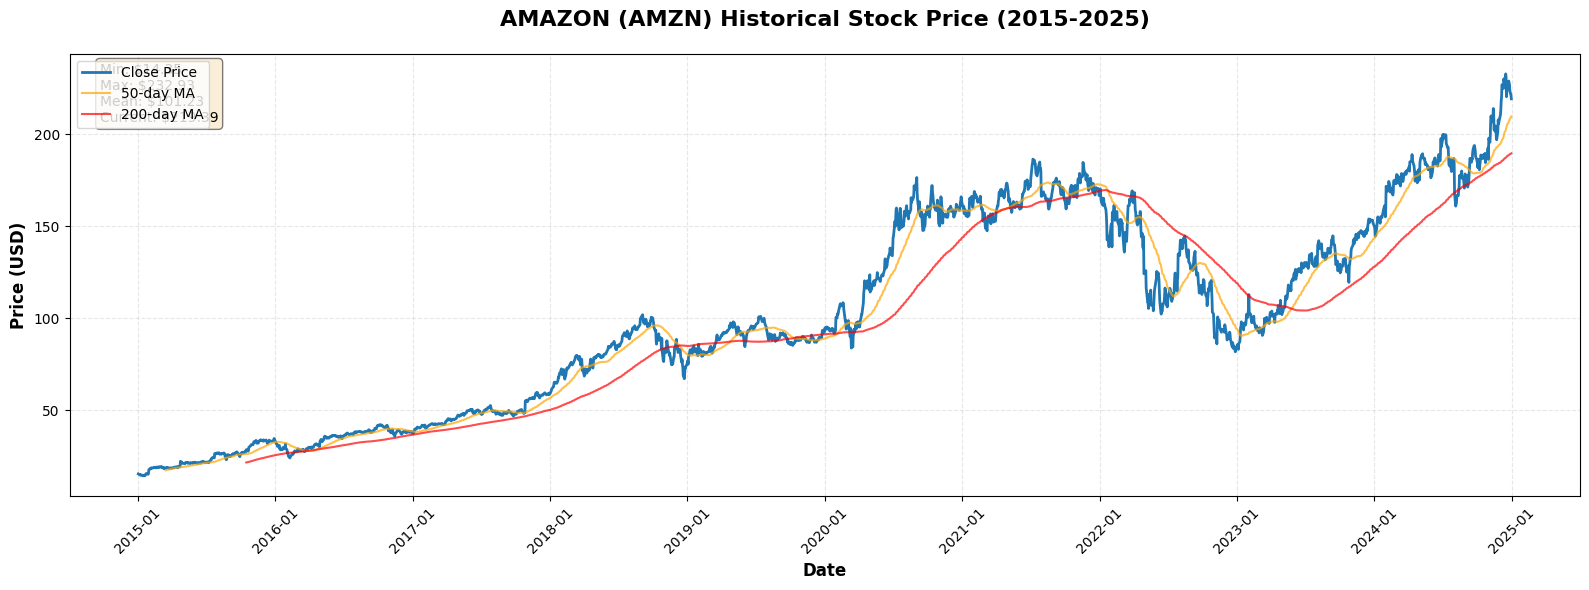

✅ Price chart created


In [12]:
#@title Plot AMAZON Historical Prices

# Create figure with larger size
fig, ax = plt.subplots(figsize=(16, 6))

# Plot close price
ax.plot(amzn_prices_pd['date'], amzn_prices_pd['close'], 
        linewidth=2, color='#1f77b4', label='Close Price')

# Add moving averages for context
amzn_prices_pd['ma_50'] = amzn_prices_pd['close'].rolling(window=50).mean()
amzn_prices_pd['ma_200'] = amzn_prices_pd['close'].rolling(window=200).mean()

ax.plot(amzn_prices_pd['date'], amzn_prices_pd['ma_50'], 
        linewidth=1.5, color='orange', alpha=0.7, label='50-day MA')
ax.plot(amzn_prices_pd['date'], amzn_prices_pd['ma_200'], 
        linewidth=1.5, color='red', alpha=0.7, label='200-day MA')

# Styling
ax.set_title('AMAZON (AMZN) Historical Stock Price (2015-2025)', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Price (USD)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='upper left', fontsize=10)

# Format x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)

# Add statistics box
stats_text = f"Min: ${amzn_prices_pd['close'].min():.2f}\n"
stats_text += f"Max: ${amzn_prices_pd['close'].max():.2f}\n"
stats_text += f"Mean: ${amzn_prices_pd['close'].mean():.2f}\n"
stats_text += f"Current: ${amzn_prices_pd['close'].iloc[-1]:.2f}"

ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
        fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("✅ Price chart created")

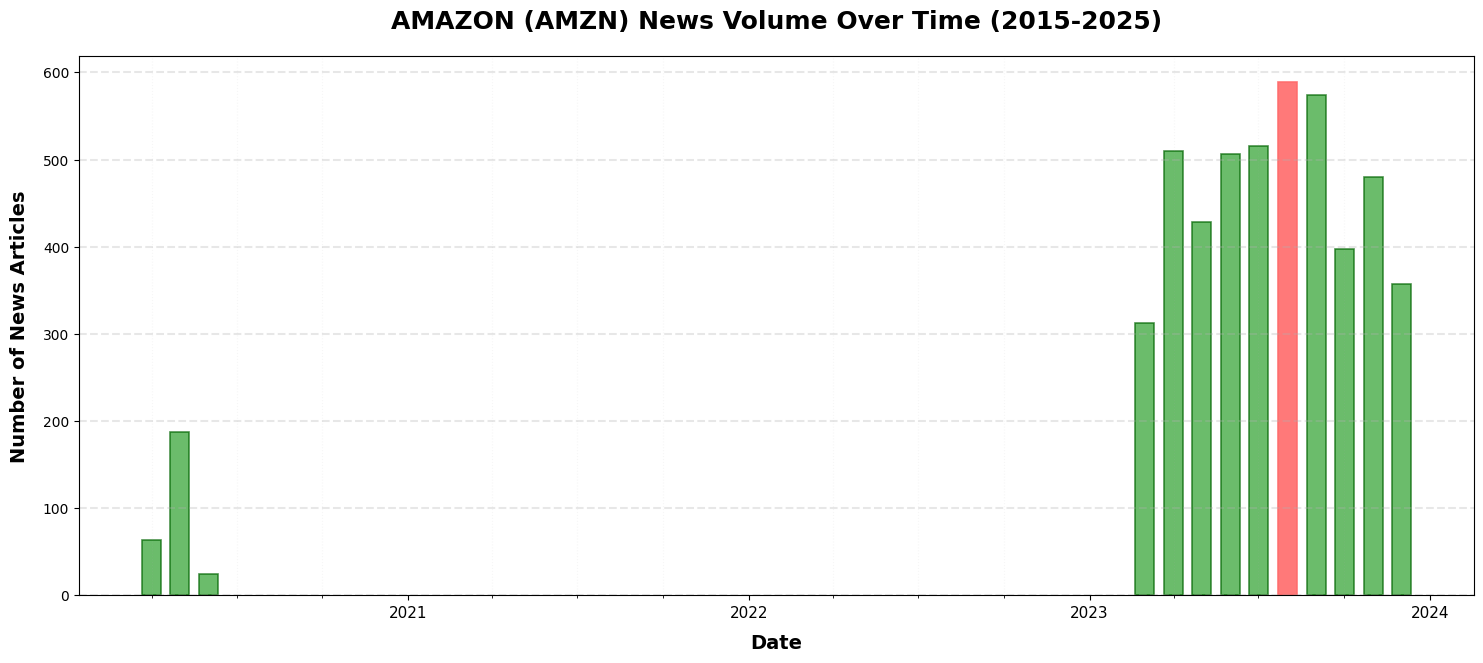

In [13]:
#@title Plot AMZN News Volume Over Time (IMPROVED)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Aggregate news by month
amzn_news_pd['year_month'] = pd.to_datetime(amzn_news_pd['date']).dt.to_period('M')
news_by_month = amzn_news_pd.groupby('year_month').size().reset_index(name='count')
news_by_month['year_month'] = news_by_month['year_month'].dt.to_timestamp()

# Create figure with better size
fig, ax = plt.subplots(figsize=(18, 7))

# Bar chart of news volume
bars = ax.bar(news_by_month['year_month'], news_by_month['count'], 
              width=20, color='#2ca02c', alpha=0.7, edgecolor='darkgreen',
              linewidth=1.2)

# Highlight peak month
peak_idx = news_by_month['count'].idxmax()
bars[peak_idx].set_color('#ff6b6b')
bars[peak_idx].set_alpha(0.9)

# Styling
ax.set_title('AMAZON (AMZN) News Volume Over Time (2015-2025)', 
             fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Date', fontsize=14, fontweight='bold', labelpad=10)
ax.set_ylabel('Number of News Articles', fontsize=14, fontweight='bold', labelpad=10)
ax.grid(True, alpha=0.3, linestyle='--', axis='y', linewidth=1.5)

# FIX: Better x-axis formatting
ax.xaxis.set_major_locator(mdates.YearLocator())  # Major ticks: years
ax.xaxis.set_minor_locator(mdates.MonthLocator((1, 4, 7, 10)))  # Minor ticks: quarters
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format: just year

# Rotate and align labels
plt.setp(ax.xaxis.get_majorticklabels(), rotation=0, ha='center', fontsize=11)

# Add minor grid for months
ax.grid(True, which='minor', alpha=0.1, linestyle=':', axis='x')

# Add statistics box
total_news = len(amzn_news_pd)
avg_per_month = news_by_month['count'].mean()
peak_date = news_by_month.loc[peak_idx, 'year_month']

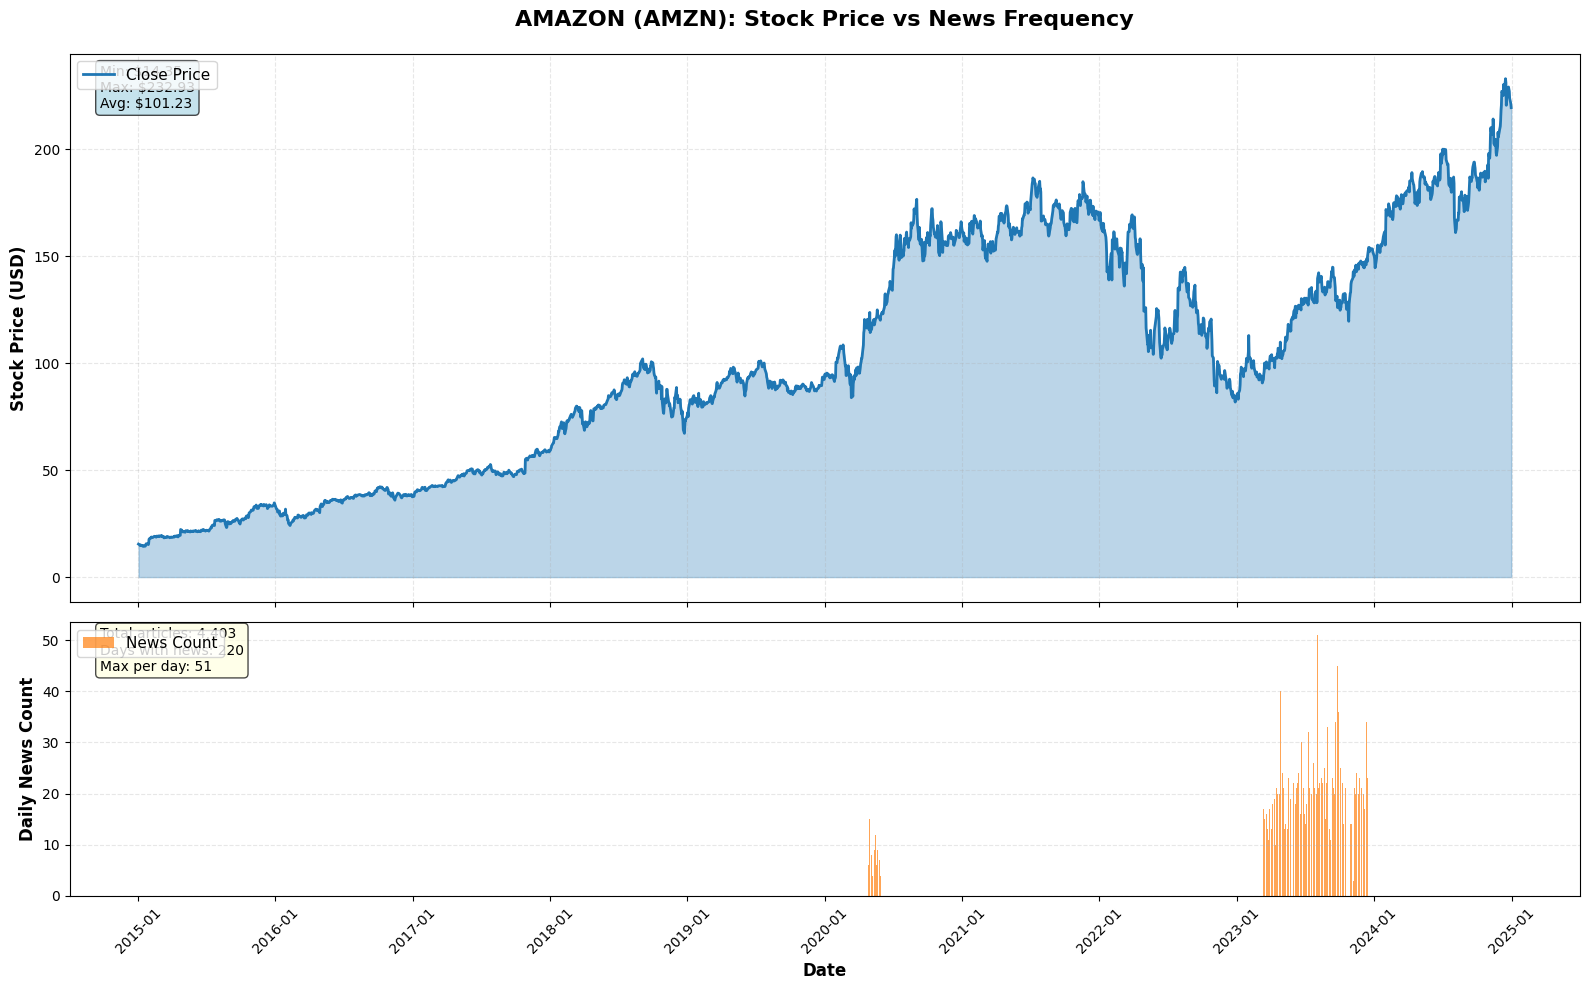

✅ Price vs News Frequency chart created

Correlation between price and news frequency: 0.130


In [14]:
#@title Plot AMZN Price vs News Frequency

# Get AMZN data
amzn_prices_pd = price_spark_df.filter(F.col("ticker") == "AMZN").toPandas()
amzn_news_pd = fnspid_spark_df.filter(F.col("ticker") == "AMZN").toPandas()

# Sort by date
amzn_prices_pd = amzn_prices_pd.sort_values('date')
amzn_news_pd = amzn_news_pd.sort_values('date')

# Calculate daily news frequency
news_frequency = amzn_news_pd.groupby('date').size().reset_index(name='news_count')

# Merge with prices (left join to keep all trading days)
amzn_prices_pd['date'] = pd.to_datetime(amzn_prices_pd['date'])
news_frequency['date'] = pd.to_datetime(news_frequency['date'])
combined_df = amzn_prices_pd.merge(news_frequency, on='date', how='left')
combined_df['news_count'] = combined_df['news_count'].fillna(0)

# Create figure with shared x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True,
                                gridspec_kw={'height_ratios': [2, 1]})

# --- Top plot: Stock Price ---
ax1.plot(combined_df['date'], combined_df['close'], 
         linewidth=2, color='#1f77b4', label='Close Price')
ax1.fill_between(combined_df['date'], combined_df['close'], 
                 alpha=0.3, color='#1f77b4')

ax1.set_title('AMAZON (AMZN): Stock Price vs News Frequency', 
              fontsize=16, fontweight='bold', pad=20)
ax1.set_ylabel('Stock Price (USD)', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.legend(loc='upper left', fontsize=11)

# Add price statistics
price_stats = f"Min: ${combined_df['close'].min():.2f}\n"
price_stats += f"Max: ${combined_df['close'].max():.2f}\n"
price_stats += f"Avg: ${combined_df['close'].mean():.2f}"
ax1.text(0.02, 0.98, price_stats, transform=ax1.transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

# --- Bottom plot: News Frequency ---
ax2.bar(combined_df['date'], combined_df['news_count'],
        width=1, color='#ff7f0e', alpha=0.7, label='News Count')

ax2.set_ylabel('Daily News Count', fontsize=12, fontweight='bold')
ax2.set_xlabel('Date', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, linestyle='--', axis='y')
ax2.legend(loc='upper left', fontsize=11)

# Add news statistics
total_news = combined_df['news_count'].sum()
days_with_news = (combined_df['news_count'] > 0).sum()
max_news_day = combined_df['news_count'].max()
news_stats = f"Total articles: {int(total_news):,}\n"
news_stats += f"Days with news: {days_with_news:,}\n"
news_stats += f"Max per day: {int(max_news_day)}"
ax2.text(0.02, 0.98, news_stats, transform=ax2.transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))

# Format x-axis
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax2.xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("✅ Price vs News Frequency chart created")
print(f"\nCorrelation between price and news frequency: {combined_df[['close', 'news_count']].corr().iloc[0, 1]:.3f}")